In [78]:


'''Preamble'''

import numpy as np
import matplotlib.pyplot as plt
import chaospy as ch
from scipy import integrate
import pandas as pd
from mpl_toolkits import mplot3d
import time
import json
import pickle
from IPython.display import Image
import pandas as pd
import datetime
import numpoly
from itertools import product
from collections import OrderedDict
from os import PathLike
import re
import os

##SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

#Chaospy
import chaospy as ch

def c(s):
    os.chdir(s)
    return os.getcwd()

''''''

x0 = 0.5
y0 = 1
z0 = 2
X = (x0,y0,z0)
t = np.linspace(0,30,1000)

problem = { ## These are the values for which we have truly crazy multimodal owl populations
    'num_vars': 7,
    'names': ['alpha','beta','delta','gamma','e','f','h'],
    'bounds': [[0.44,0.68],
               [0.02,0.044],
               [0.71,1.15],
               [0.0226,0.0354],
               [0.03,0.055],
               [0.71,1.15],
               [0.02,0.03]]}

def lotka3(X,t,a,b,d,g,e,f,h):
    x, y, z = X
    dotx = x * (a - b * y)
    doty = y * (-d + (g * x) - e * z) 
    dotz = z * (-f + h*y)
    return np.array([dotx, doty, dotz])

distributions = []

for idx,name in enumerate(problem['names']):
    a,b = problem['bounds'][idx]
    distributions.append(ch.Uniform(a,b))
    
joint = ch.J(*distributions)

dick = {}

vectors = np.identity(len(joint), dtype='int')

gt_df = pd.read_csv('./data/lotka3/lotka3_GT_524288.csv',index_col=['type','params']).ST
gt = gt_df.loc[f'{species}']
gt_norm = np.linalg.norm(gt)


growth=False
recurrence_algorithm='stieltjes'
rule='g'
tolerance=1e-10
scaling=3
n_max=50000


def _construct_lookup(
        orders,
        dists,
        growth,
        recurrence_algorithm,
        rules,
        tolerance,
        scaling,
        n_max,
):
    """
    Create abscissas and weights look-up table so values do not need to be
    re-calculatated on the fly.
    """
    x_lookup = []
    w_lookup = []

    for order, dist in zip(max_order_vector, dists):
        x_lookup.append([])
        w_lookup.append([])
        for orderr in range(max_order + 1):
            (abscissas,), weights = ch.generate_quadrature(
                order=orderr,
                dist=dist,
                growth=growth,
                recurrence_algorithm=recurrence_algorithm,
                rule=rule,
                tolerance=tolerance,
                scaling=scaling,
                n_max=n_max,
            )
            x_lookup[-1].append(abscissas)
            w_lookup[-1].append(weights)
    return x_lookup, w_lookup


def construct_wrapper(maxx):
    global max_order_vector, max_order
    global x_lookup, w_lookup

    max_order = maxx
    max_order_vector = max_order * np.ones(len(joint), dtype=int)
    # print(max_order_vector)

    x_lookup, w_lookup = _construct_lookup(
        orders=max_order_vector,
        dists=joint,
        growth=growth,
        recurrence_algorithm=recurrence_algorithm,
        rules=rule,
        tolerance=tolerance,
        scaling=scaling,
        n_max=5000)

    return x_lookup, w_lookup

x_lookup, w_lookup = construct_wrapper(10)


def generate_candidates(index_set, P):
    global candidates, pre_candidates, back_neighbours

    pre_candidates = []
    candidates = []

    for j in range(0, len(joint)):
        pre_candidates.append(index_set + vectors[j])

    for candidate in pre_candidates:
        back_neighbours = []
        for j in range(0, len(joint)):
            back_neighbour = candidate - vectors[j]
            if np.all((back_neighbour > 1)):
                back_neighbours.append(tuple(back_neighbour))

        if np.all([neighbour in old for neighbour in back_neighbours]):
            candidates.append(tuple(candidate))

    temp = []
    for candidate in candidates:
        # if candidate not in old:
        if np.all(np.array(candidate) <= P) and np.linalg.norm(np.array(candidate),ord=1) <= (P+6):
            temp.append(candidate)

    candidates = temp

    temp = []
    maxx = sum(np.max(np.array(old), axis=0))

    for candidate in candidates:

        if sum(np.max(np.array(old + [candidate]), axis=0)) > maxx:
            temp.append(candidate)

    candidates = temp

    return candidates

def sobol_error(vec):
    return np.linalg.norm(gt - vec) / gt_norm


def solver(old_set,target):

    global poly

    solver_time = time.perf_counter()

    nodes_list = []
    weights_list = []
    evals_list = []

    for index in old_set:
        nodes, weights = build_nodes_weights(index)
        weights = [weight * combinator(index) for weight in weights]

        nodes_list += nodes
        weights_list += weights

    for node in nodes_list:

        if node in dick.keys():
            evals_list.append(dick[node])

        else:
            a, b, d, g, e, f, h = node
            solution = integrate.odeint(lotka3, X, t, args=(a, b, d, g, e, f, h)).T[target][910]
            evals_list.append(solution)
            dick[node] = solution

    nodes_list = np.array(nodes_list).T

    polly = ch.fit_quadrature(expansion, nodes_list, weights_list, evals_list)
    poly.append(polly)
    print('Solver_time >>>', time.perf_counter() - solver_time)
    print('Weight sum >>>', sum(weights_list))
    return len(weights_list)


def assign_errors(active_set):
    global active_errors, active, candidates, current_errors, new
    active_errors = []
    
    maxx = sum(np.max(np.array(old), axis=0))
    
    for multi_index in active_set:
        if (step > 0) and sum(np.max(np.array(old + [multi_index]), axis=0)) <= maxx:
            active_set.remove(multi_index)
        

    for multi_index in active_set:
        nodes, _ = build_nodes_weights(multi_index)
        current_errors = []

        for node in nodes:
            a, b, d, g, e, f, h = node
            if np.isnan(poly[-1](a, b, d, g,e,f,h)):
                poly_eval = 0
            else:
                poly_eval = poly[-1](a, b, d, g,e,f,h)

            if node in dick.keys():
                current_errors.append(abs(dick[node] - poly_eval))

            else:
                solution = integrate.odeint(lotka3, X, t, args=(a, b, d, g, e,f,h)).T[0][910]
                current_errors.append(abs(solution - poly_eval))

        active_errors.append(np.mean(current_errors))

    active = sorted(list(zip(active_set, active_errors)), key=lambda x: x[1])

    return active
    # active = [i for i in OrderedDict((tuple(x[0]), x) for x in active).values()]if np.isnan(poly[-1](1,2,3,4)):

def algorithm(P,species):
    
    global dick, old, candidates, poly, active, global_errors, no_nodes,step, expansion
    
    '''Initialise'''
    
    if species == 'mouse':
        target = 0
        
    elif species == 'snake':
        target = 1
        
    elif species == 'owl':
        target = 2
    
    expansion = ch.generate_expansion(P, joint)
    vectors = np.identity(len(joint), dtype='int')
    date_today = datetime.date.today()
    start_time = time.perf_counter()
    
    step = 0
    
    old = [(1,1,1,1,1,1,1)]
    active = []
    poly = []
    
    local_errors = []
    global_errors = []
    
    names = problem['names']
    
    df = pd.DataFrame(columns=['chosen_index','local_error','global_error','no_nodes','run_time'])
    df_indices = pd.DataFrame(columns=['alpha','beta','delta','gamma','e','f','g'])
    df_indices_s1 = pd.DataFrame(columns=['alpha','beta','delta','gamma','e','f','g'])

    
    '''Execute zeroth step'''
    
    solver(old,target)
    assign_errors(old)
    
    
    st = ch.Sens_t(poly[-1], joint)
    s1 = ch.Sens_m(poly[-1], joint)
    
    global_errors.append(sobol_error(st))
    
    print('Global error >>>', global_errors[-1])
    print('Step time >>>', time.perf_counter() - start_time, 'seconds')
    print('-'*10,'break','-'*10)


    '''Main loop'''
    
    while (global_errors[-1] > 0.1 or np.isnan(global_errors[-1])) and len(active)>0:
        
        start_time = time.perf_counter()
        
        print('Active >>>',active)
        chosen_index = active[-1][0]
        local_errors.append(active[-1][1])
        active.pop()
    
        old.append(chosen_index)
        
        print('Chosen index >>>', chosen_index)
        
        number_nodes = solver(old,target)
        
        candidates = generate_candidates(chosen_index,P)
        print(candidates)
        stripped_active = [i[0] for i in active] + [j for j in candidates]
        active = assign_errors(stripped_active)
        
        sobol_time = time.perf_counter() 

        st = ch.Sens_t(poly[-1], joint)
        s1 = ch.Sens_m(poly[-1], joint)
        
        print('Sobol time >>>', time.perf_counter() - sobol_time)
        
        global_errors.append(sobol_error(st))

        print('Global error >>>', global_errors[-1])
        
        '''Save data'''
        run_time = time.perf_counter() - start_time
        
        numpoly.savez(f'./data/lotka3/{species}/poly_{P}+{date_today}.npz',*poly)
        
        df_indices = df_indices.append({'alpha': st[0], 'beta': st[1], 'delta': st[2], 'gamma': st[3], 'e': st[4],'f': st[4],'h':st[6]         }, ignore_index=True)
        df_indices_s1 = df_indices_s1.append({'alpha': s1[0], 'beta': s1[1], 'delta': s1[2], 'gamma': s1[3], 'e': s1[4],'f': s1[4],'h':s1[6]            }, ignore_index=True)
        df = df.append({'chosen_index': chosen_index,'local_error':local_errors[-1],                               'global_error':global_errors[-1],'no_nodes':number_nodes, 'run_time':run_time}, ignore_index=True)
        
        df.to_csv(f'./data/lotka3/{species}/run_file_{P}+{date_today}.csv')
        df_indices.to_csv(f'./data/lotka3/{species}/total_order_indices_{P}+{date_today}.csv')
        df_indices_s1.to_csv(f'./data/lotka3/{species}/first_order_indices_{P}+{date_today}.csv')

        print('Step time >>>', time.perf_counter() - start_time, 'seconds')
        print('-'*10,'break','-'*10)
        
        step += 1
        
    print('Congratulations, the algorithm has converged!')
    print('Here are the results...')
    print('-'*20)
    print(f'ST_alpha:{st[0].round(4)}, ST_beta:{st[1].round(4)}, ST_delta:{st[2].round(4)}, ST_gamma:{st[3].round(4)}')
    print(f'GT_alpha:{gt[0].round(4)}, GT_beta:{gt[1].round(4)}, GT_delta:{gt[2].round(4)}, GT_gamma:{gt[3].round(4)}')
    print(f'The final grid contains {number_nodes} nodes.')
    print(f'The total run time was {df.run_time.sum()}seconds, not bad!')
          

def combinator(current_index):
    
    coeff = 1
    
    for vector in vectors:
        
        if tuple(np.array(current_index, dtype='int') + vector) in old:
            
            coeff += -1
            
    return coeff 

def build_nodes_weights(current_index):
    
    nodestack = []
    weightstack = []
    
    '''Nodes'''
    
    for index,element in enumerate(current_index):
        nodestack.append([])
        nodestack[index] = list(x_lookup[index][element])
        
    nodes = nodestack[0]
    
    for i in range(1,len(nodestack)):
        nodes = product(nodes,nodestack[i])
        
    nodes = [(a,b,c,d,e,f,g) for ((((((a,b),c),d),e),f),g) in nodes]
    
    '''Weights'''
    
    for index,element in enumerate(current_index):
        weightstack.append([])
        weightstack[index] = list(w_lookup[index][element])
        
    weights = weightstack[0]
    
    for i in range(1,len(weightstack)):
        weights = product(weights,weightstack[i])
        
    weights = [(a*b*c*d*e*f*g) for ((((((a,b),c),d),e),f),g) in weights]
    
    
    return nodes,weights
        
def wrapper():
    
    orders = [1,2,4,5,6]
    o = [1,2,3,4,5,6]
    
    for order in orders:
        algorithm(order,species='prey')
        
    for order in o:
        algorithm(order,species='predator')

algorithm(3,'mouse')








Solver_time >>> 0.5455496999984462
Weight sum >>> 0.9999999999999998
Global error >>> nan
Step time >>> 261.81911339999897 seconds
---------- break ----------
Active >>> [((1, 1, 1, 1, 1, 1, 1), 69.50832025543997)]
Chosen index >>> (1, 1, 1, 1, 1, 1, 1)
Solver_time >>> 0.10084620000088762
Weight sum >>> 1.9999999999999998
[(2, 1, 1, 1, 1, 1, 1), (1, 2, 1, 1, 1, 1, 1), (1, 1, 2, 1, 1, 1, 1), (1, 1, 1, 2, 1, 1, 1), (1, 1, 1, 1, 2, 1, 1), (1, 1, 1, 1, 1, 2, 1), (1, 1, 1, 1, 1, 1, 2)]
Sobol time >>> 234.56911190000028
Global error >>> nan
Step time >>> 249.0346769000007 seconds
---------- break ----------
Active >>> [((2, 1, 1, 1, 1, 1, 1), 51.09665198141844), ((1, 2, 1, 1, 1, 1, 1), 66.5025862020821), ((1, 1, 2, 1, 1, 1, 1), 69.00740439954804), ((1, 1, 1, 1, 1, 2, 1), 69.37032398625415), ((1, 1, 1, 1, 2, 1, 1), 69.51866634917526), ((1, 1, 1, 1, 1, 1, 2), 69.59531245701763), ((1, 1, 1, 2, 1, 1, 1), 71.01095259403945)]
Chosen index >>> (1, 1, 1, 2, 1, 1, 1)
Solver_time >>> 0.658634199999141

In [138]:
species

'owl'

In [81]:
generate_candidates((1, 1, 1, 2, 2, 1, 1),3)

[]

In [59]:
def generate_candidates(index_set, P):
    global candidates, pre_candidates, back_neighbours

    pre_candidates = []
    candidates = []

    for j in range(0, len(joint)):
        pre_candidates.append(index_set + vectors[j])

    for candidate in pre_candidates:
        back_neighbours = []
        for j in range(0, len(joint)):
            back_neighbour = candidate - vectors[j]
            if np.all((back_neighbour > 0)):
                back_neighbours.append(tuple(back_neighbour))

        if np.all([neighbour in old for neighbour in back_neighbours]):
            candidates.append(tuple(candidate))

    temp = []
    for candidate in candidates:
        # if candidate not in old:
        if np.all(np.array(candidate) <= P) and np.linalg.norm(np.array(candidate),ord=1) <= (P+6):
            temp.append(candidate)

    candidates = temp

    temp = []
    maxx = sum(np.max(np.array(old), axis=0))

    for candidate in candidates:

        if sum(np.max(np.array(old + [candidate]), axis=0)) > maxx:
            temp.append(candidate)

    candidates = temp

    return candidates


(1, 1, 1, 1, 1, 1, 1)

In [105]:
c('data/lotka3/mouse')

'C:\\Users\\jeffr\\OneDrive\\Documents\\Education\\Thesis\\Scripts\\adaptive_solver\\data\\lotka3\\mouse'

In [113]:
poly = numpoly.load('poly_3+2022-04-19.npz')
#st = ch.Sens_t(poly,joint)

In [128]:
st = ch.Sens_t(test,joint)

7

<BarContainer object of 7 artists>

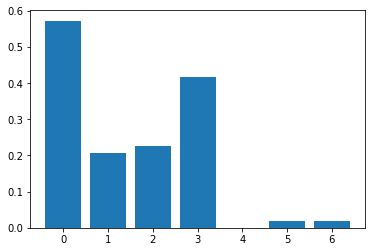

In [137]:
plt.bar(height=st,x=np.arange(len(list(st))))

In [130]:
sobol_error(st)

0.804576765549625

In [125]:
test = poly[list(poly.keys())[-1]]


In [ ]:
OneDrive/Documents/Education/Thesis/Scripts/adaptive_solver/data/lotka3/mouse/poly_3+2022-04-19.npz

In [91]:
pre_candidates

[array([2, 1, 1, 2, 2, 1, 1]),
 array([1, 2, 1, 2, 2, 1, 1]),
 array([1, 1, 2, 2, 2, 1, 1]),
 array([1, 1, 1, 3, 2, 1, 1]),
 array([1, 1, 1, 2, 3, 1, 1]),
 array([1, 1, 1, 2, 2, 2, 1]),
 array([1, 1, 1, 2, 2, 1, 2])]

In [100]:
l = []
for candidate in pre_candidates:
    back_neighbours = []
    for j in range(0, len(joint)):
        back_neighbour = candidate - vectors[j]
        l.append(back_neighbour)
        if np.all((back_neighbour > 1)):
            back_neighbours.append(tuple(back_neighbour))
back_neighbours

[]

In [102]:
test = l[0]
test

array([1, 1, 1, 2, 2, 1, 1])

In [103]:
np.all(test>1)

False

In [97]:
pre_candidates

[array([2, 1, 1, 2, 2, 1, 1]),
 array([1, 2, 1, 2, 2, 1, 1]),
 array([1, 1, 2, 2, 2, 1, 1]),
 array([1, 1, 1, 3, 2, 1, 1]),
 array([1, 1, 1, 2, 3, 1, 1]),
 array([1, 1, 1, 2, 2, 2, 1]),
 array([1, 1, 1, 2, 2, 1, 2])]

In [87]:
len(joint
   )

7

In [89]:
vectors.shape

(7, 7)

In [82]:
pre_candidates

[array([2, 1, 1, 2, 2, 1, 1]),
 array([1, 2, 1, 2, 2, 1, 1]),
 array([1, 1, 2, 2, 2, 1, 1]),
 array([1, 1, 1, 3, 2, 1, 1]),
 array([1, 1, 1, 2, 3, 1, 1]),
 array([1, 1, 1, 2, 2, 2, 1]),
 array([1, 1, 1, 2, 2, 1, 2])]

In [84]:
candidates

[]

In [63]:
build_nodes_weights(old[0])

([((((0.490717967697245, 0.025071796769724493), 0.8029829407782823),
    0.025304958277186394),
   0.03528312163512968,
   0.8029829407782823,
   0.022113248654051874),
  ((((0.490717967697245, 0.025071796769724493), 0.8029829407782823),
    0.025304958277186394),
   0.03528312163512968,
   0.8029829407782823,
   0.02788675134594813),
  ((((0.490717967697245, 0.025071796769724493), 0.8029829407782823),
    0.025304958277186394),
   0.03528312163512968,
   1.0570170592217176,
   0.022113248654051874),
  ((((0.490717967697245, 0.025071796769724493), 0.8029829407782823),
    0.025304958277186394),
   0.03528312163512968,
   1.0570170592217176,
   0.02788675134594813),
  ((((0.490717967697245, 0.025071796769724493), 0.8029829407782823),
    0.025304958277186394),
   0.04971687836487032,
   0.8029829407782823,
   0.022113248654051874),
  ((((0.490717967697245, 0.025071796769724493), 0.8029829407782823),
    0.025304958277186394),
   0.04971687836487032,
   0.8029829407782823,
   0.027886751

In [55]:
old

[(1, 1, 1, 1, 1, 1, 1)]

In [28]:
species='owl'
gt.loc[f'{species}']

params
alpha    0.675247
beta     0.762646
delta    0.007383
gamma    0.091910
e        0.045190
f        0.671680
h        0.500192
Name: ST, dtype: float64

In [32]:
c('..')

'C:\\Users\\jeffr\\OneDrive\\Documents\\Education\\Thesis\\Scripts\\adaptive_solver'

In [36]:
xs.shape

(8,)

In [ ]:
gt.h

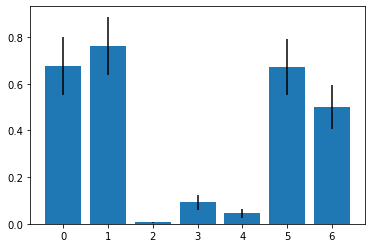

In [41]:
test = pd.read_csv('./data/lotka3/lotka3_GT_524288.csv',index_col=['type','params'])

fig,ax = plt.subplots()
xs = np.arange(0,7)
a = plt.bar(xs,height=test.loc['owl'].ST,yerr=test.loc['owl'].ST_conf)

In [27]:
gt = pd.read_csv('.data/lotka3/lotka3_GT_524288.csv',index_col=['type','params']).ST
gt

type   params
mouse  alpha     0.974165
       beta      0.119318
       delta     0.289952
       gamma     0.339779
       e         0.001567
       f         0.040612
       h         0.032255
snake  alpha     0.976484
       beta      0.184493
       delta     0.299378
       gamma     0.293956
       e         0.003226
       f         0.085792
       h         0.065510
owl    alpha     0.675247
       beta      0.762646
       delta     0.007383
       gamma     0.091910
       e         0.045190
       f         0.671680
       h         0.500192
Name: ST, dtype: float64